# Logistic Regression vs. Bayesian Classifier
## Discriminative vs Generative Models

### Task I: Load training and test data and Implementing Bayesian Classifier and Logistic Regression

In [4]:
options(warn=-1)
library(ggplot2)
library(mvtnorm)
library(reshape2)

In [5]:
dtrain <- read.csv(file = "Task1E_train.csv",head=TRUE,sep=",") # loading training data used to train the model
dtest <- read.csv(file = "Task1E_test.csv",head=TRUE,sep=",") # test data to test the performance of learned model

In [6]:
## Split data to train and labels
train.data = dtrain[-3]
test.data = dtest[-3]

train.label = dtrain[,3]
test.label = dtest[,3]

c0 <- '1'; c1 <- '-1' # class labels

In [7]:
sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE) # shared covariance matrix
sigma0 <- sigma;   sigma1 <- sigma

### Auxilary Function

In [8]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

### Implementing Bayesian Classifier
These are the steps to build a bayesian Classifier:
<ol>
	<li>Calculate the class priors $p(\mathcal{C}_k)$ based on the relative number of training data in each class,</li>
	<li>Calculate the class means $\mu_k$, class covariance matrices $\mathbf{S}_k$ and shared covariance matrix $\Sigma$ using the training data,</li>
	<li>Using the estimated PDF function, calculate $p(x_n|\mathcal{C}_k)$ for each data point and each class,</li>
	<li>For each test sample, find the class label $\mathcal{C}_k$ that maximizes the $p(\mathcal{C}_k)p(x_n|\mathcal{C}_k)$,</li>
</ol>
###### <span style="color: red">Code used here is adopted from "Activity.3.2.ipynb" file form Module 3.</span>

In [9]:
bayesian_classifier <- function(train.data, train.label, test.label, test.data){
    # Class probabilities:
    p0.hat <- sum(train.label==c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    test.error <- sum(test.label != test.predict)/nrow(test.data)*100
}

### Implementing of Logistic Regression
These are the steps is neccesseary to build a logistic regression:
<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the followings until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

In [13]:
logistic_regression <- function(train.data, train.label, test.label, test.data){
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE
    
    train.len <- nrow(train.data)
    
        ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
    }
}
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    
    w <- W[tau,]
    
    # calculate predictions:
    test.predict <- predict(w, test.data, c0, c1)

    test.error <- sum(test.label != test.predict)/nrow(test.data)*100
    
   }

In [14]:
# For loop to increase the size of training set (5 data points at a time) and calculate test errors for both 
# Bayesian Classifier and Logistic Regression models until all training
sample_seq = seq(from = 5, to = nrow(dtrain), by = 5)


er_test = matrix(0, nrow = length(sample_seq), ncol = 3) # empty matrix to store test errors for Bayesian Classifier


colnames(er_test) = c('trainSetSize', 'testErrorsBayesian', 'testErrorsLR')
mat_index = 1 # matrix index to store test errors
for (size in sample_seq){
   
    er_test[mat_index, 1] = size
    er_test[mat_index, 2] = bayesian_classifier(train.data[1:size,], train.label[1:size], test.label, test.data)
    er_test[mat_index, 3] = logistic_regression(train.data[1:size,], train.label[1:size], test.label, test.data)
    mat_index = mat_index + 1
    

}


### Plot test errors for both Bayesian Classifier and Logistic Regression models

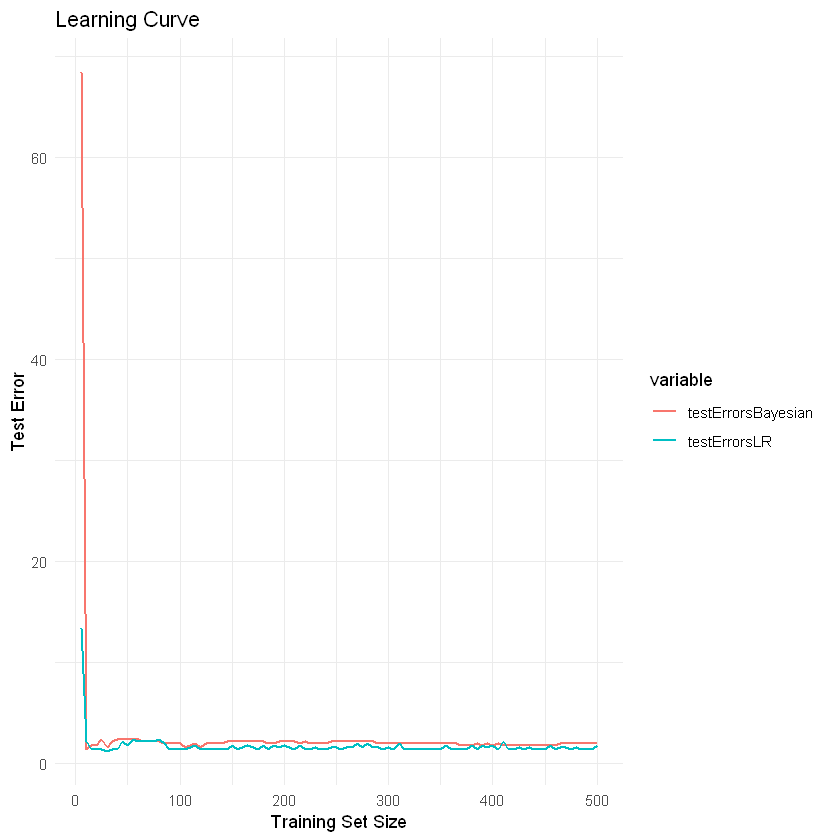

In [12]:
er_test.m <- melt(as.data.frame(er_test), id='trainSetSize')
ggplot(data=er_test.m, aes(x = trainSetSize, y = value, color=variable)) + geom_line(size=.75) + 
        labs(title='Learning Curve', x = "Training Set Size", y = "Test Error") +  theme_minimal()

### Task III: Observations
- A) What does happen for each classifier when the number of training data points is increased?
    
    Initially, when the training data points are increased from 5 to 30 (in five point steps), test error for both Bayesian Classifier and Logistic Regression is reduced to zero. After 30 data points, test error for both Bayesian Classifier and Logistic Regression increases to its maximum at 35 data points. Then, test error for both Bayesian Classifier and Logistic Regression fluctuates for different data points.
    

    
- B) Which classifier is best suited when the training set is small, and which is best suited when the training set is big?
    
    In the given case, LR model is relatively more suitable for both small and big training set sizes. This can be seen from the error rate plot. For all training data points sizes, test error for LR model is less than or equal to error for Bayesian Classifier.

    
- C) Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons. 
    
    * Both models performed well even though we had only two parameters. Possible reason could be that the data is easily separable by single decision boundary. </li>
    * From mini-batch 5 to 140 both classifiers have same prediction and error rate. </li>